<a href="https://colab.research.google.com/github/rudysemola/ComputerVisionEngineer-ImageClassification/blob/main/ImageClassification_TFhub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification - TF Hub & plant_village



## Setup

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

## Simple transfer learning

But what if you want to train a classifier for a dataset with different classes? You can also use a model from TFHub to train a custom image classier by retraining the top layer of the model to recognize the classes in our dataset.

### Dataset Plant

In [2]:
import tensorflow_datasets as tfds

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'plant_village',
    split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.2.incomplete1ZM3HE/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [3]:
def configure_for_performance(ds, batch_size=32):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [5]:
batch_size = 32
img_height = 224
img_width = 224

num_classes = metadata.features['label'].num_classes
print(num_classes)

38


### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [compatible image feature vector model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [6]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_width, img_height),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [7]:
train_ds_aug = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [8]:
val_ds_aug = val_ds.map(
  lambda x, y: (resize_and_rescale(x, training=False), y))

In [9]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [10]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [68]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax') #
])

### Train the model

Use compile to configure the training process:

In [69]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(), #from_logits=True
  metrics=['acc'])

In [70]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 38)                48678     
Total params: 2,306,662
Trainable params: 48,678
Non-trainable params: 2,257,984
_________________________________________________________________


Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [22]:
loss0, accuracy0 = model.evaluate(val_ds_aug)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

340/340 [==============================] - 29s 82ms/step - loss: 4.0051 - acc: 0.0294
initial loss: 4.01
initial accuracy: 0.03


In [71]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    self.batch_losses_val = []
    self.batch_acc_val = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.batch_losses_val.append(logs['val_loss'])
    self.batch_acc_val.append(logs['val_acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds_aug, epochs=4, validation_data=val_ds_aug)

Epoch 1/4
1188/1188 [==============================] - 128s 107ms/step - loss: 0.4700 - acc: 0.8731 - val_loss: 0.2101 - val_acc: 0.9364
Epoch 2/4
1188/1188 [==============================] - 125s 105ms/step - loss: 0.1918 - acc: 0.9403 - val_loss: 0.1748 - val_acc: 0.9434
Epoch 3/4
1188/1188 [==============================] - 141s 119ms/step - loss: 0.1461 - acc: 0.9542 - val_loss: 0.1495 - val_acc: 0.9510
Epoch 4/4
1188/1188 [==============================] - 127s 107ms/step - loss: 0.1283 - acc: 0.9585 - val_loss: 0.1401 - val_acc: 0.9531


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

In [16]:
def plot_hist(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

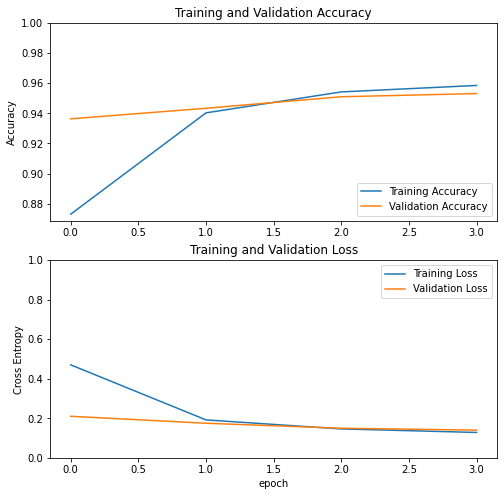

In [72]:
plot_hist(history)

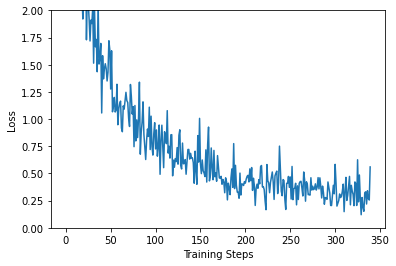

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

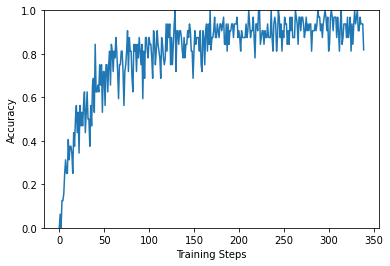

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions & Evaluate final model

To redo the plot from before, first get the ordered list of class names:

In [73]:
#loss_final, accuracy_final = model.evaluate(val_ds_aug)
#print("Final loss (VL): {:.2f}".format(loss_final))
#print("Final accuracy (VL): {:.2f}".format(accuracy_final))

test_ds_aug = test_ds.map(
  lambda x, y: (resize_and_rescale(x, training=False), y))

loss_final, accuracy_final = model.evaluate(test_ds_aug)
print("Final loss (TEST): {:.3f}".format(loss_final))
print("Final accuracy (TEST): {:.3f}".format(accuracy_final))

170/170 [==============================] - 14s 85ms/step - loss: 0.1349 - acc: 0.9569
Final loss (TEST): 0.135
Final accuracy (TEST): 0.957


In [77]:
import PIL
from PIL import Image
import requests

img_uva_url = "https://www.vinook.it/uva-e-vitigni/curiosita-uva/foglia-uva_O1.jpg"
img_uvaMalata_url = "https://www.giardinaggio.it/parassiti/avversitafrutti/parte3a_NG1.jpg"
im = Image.open(requests.get(img_uva_url, stream=True).raw)
im_mal = Image.open(requests.get(img_uvaMalata_url, stream=True).raw)
image_array  = tf.keras.preprocessing.image.img_to_array(im)
image_array_mal  = tf.keras.preprocessing.image.img_to_array(im_mal)
#chech the shape
image_array.shape, image_array_mal.shape

((417, 393, 3), (497, 745, 3))

In [75]:
image_batch = image_array[np.newaxis, ...]
image_batch_mal = image_array_mal[np.newaxis, ...]

prediction_input_model = resize_and_rescale(image_batch)
prediction = model.predict(prediction_input_model)
print("Shape result prediction: ",prediction.shape)

prediction_input_model_mal = resize_and_rescale(image_batch_mal)
prediction_mal = model.predict(prediction_input_model_mal)
print("Shape result prediction: ",prediction_mal.shape)

Shape result prediction:  (1, 38)
Shape result prediction:  (1, 38)


In [54]:
get_label_name = metadata.features['label'].int2str
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=38)>

In [ ]:
def predict(prediction):
    class_idx = np.argmax(prediction[0])
    classe = get_label_name(class_idx)
    
    return get_label_name(np.argmax(prediction[0])), prediction[0][class_idx]

('Grape___healthy', 0.6153663)


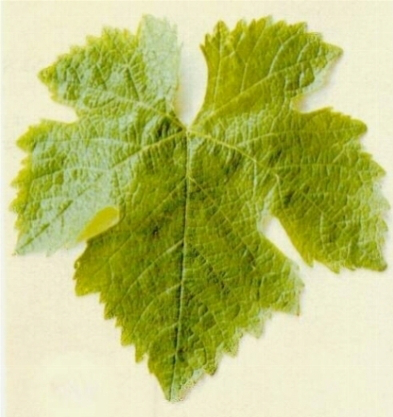

In [82]:
print(predict(prediction))
im

('Strawberry___Leaf_scorch', 0.47804698)


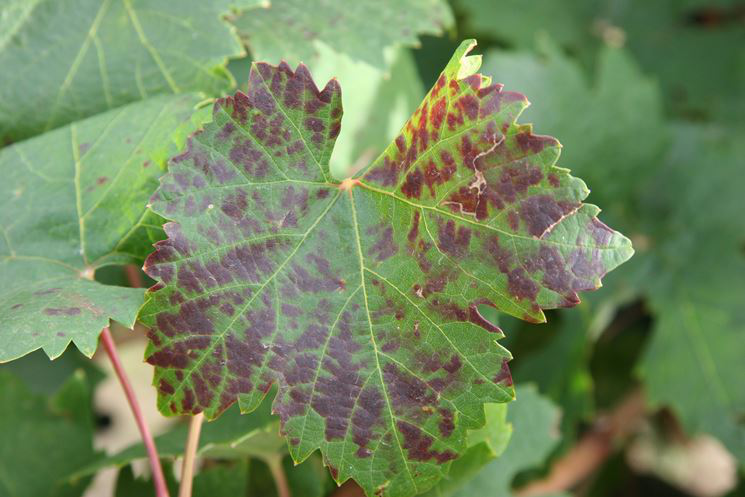

In [83]:
print( predict(prediction_mal) )
im_mal

## Export your model

Now that you've trained the model, export it as a SavedModel for use later on.

In [86]:
export_path = "/content/My_model"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /content/My_model/assets


INFO:tensorflow:Assets written to: /content/My_model/assets


'/content/My_model'

Now confirm that we can reload it, and it still gives the same results:

In [87]:
reloaded = tf.keras.models.load_model(export_path)

In [90]:
#tua immagine
prediction_input_model = resize_and_rescale(image_batch)
prediction_reoladed = reloaded.predict(prediction_input_model)
print("Shape result prediction: ",prediction_reoladed.shape)
print( predict(prediction_reoladed) )

Shape result prediction:  (1, 38)
('Grape___healthy', 0.6153663)


In [92]:
prediction_reoladed[0]

array([3.2663706e-04, 1.1776833e-06, 1.6393471e-07, 5.4635252e-03,
       5.0437232e-10, 7.9414049e-09, 2.6456539e-06, 2.8451328e-07,
       2.5971509e-08, 1.0201811e-06, 4.4176307e-09, 9.0449961e-04,
       8.7966472e-03, 6.1536628e-01, 1.0643218e-01, 2.3697385e-13,
       3.6879194e-07, 2.9740080e-13, 1.8269088e-12, 2.0605125e-15,
       2.9576219e-08, 1.2744347e-12, 4.6286837e-09, 2.7909996e-07,
       1.1039980e-09, 2.5851476e-01, 1.5344760e-08, 4.8808356e-06,
       3.2555415e-06, 2.1122664e-06, 5.7529024e-07, 4.1600773e-03,
       2.1178252e-08, 1.7933797e-05, 1.4097361e-10, 2.9335087e-08,
       4.2654793e-08, 5.8147521e-07], dtype=float32)

In [93]:
# possiamo usare questo approccio... passa p[0] come input!
prob = tf.nn.softmax([-1.2, 0.5, 2])
prob

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.03225132, 0.17654206, 0.7912066 ], dtype=float32)>

This SavedModel can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).


### Plus code
- save model
- download tr model
- load
- inference

In [ ]:
#TODO download...
"es. zip file e scaricalo..."